# Gaussian Mixture Model
## Angus Mackenzie - 1106817
In this project we are tasked with creating a Gaussian Mixture Model (GMM) that can detect coins. It should be able to produce a mask that shows coin pixels in white and desk pixels in black. 

We need to run our code with 1-10 components and report the accuracy of our system. 

GMM's work by proposing multiple Gaussian's, tweaking their parameters and then updating them. Eventually meeting a specific criteria at which they stop. We can create a generative model, and give it a posterior and generate the probability of the point. The number of components gives us the number of distributions to tweak.

In [1]:
import numpy as np
from scipy import stats
import cv2
import matplotlib.pyplot as plt
from mpmath import *
from tqdm.auto import tqdm
import os
import time

In [2]:
def read_image(name, display=True):
    """
    Given an image, reads it in with CV and plots it with the title
    returns the image
    """
    img = cv2.imread(name,-1)
    if display:
        t = "BGR "+name
        plt.title(t)
        plt.imshow(img)
        plt.show()
    return img

def show_components(bgr,title):
    """
    Given a BGR image, converts it to HSV and displays
    each aspect of BGR and HSV
    """
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
    b = bgr[:,:,0]
    g = bgr[:,:,1]
    r = bgr[:,:,2]
    h = hsv[:,:,0]
    s = hsv[:,:,1]
    v = hsv[:,:,2]
    components = [b,g,r,h,s,v]
    comps = ['Blue','Green','Red','Hue','Saturation','Value']
    fig=plt.figure(figsize=(12, 10))
    t = "Different Components of "+str(title)
    fig.suptitle(t)
    columns = 3
    rows = 2
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(components[i-1],cmap="gray")
        # one liner to remove *all axes in all subplots*
        plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
        plt.title(comps[i-1])
    plt.savefig("Components.png")
    plt.show()
    
def plot_image(img,title, gray=True):
    """
    Given an image and a title, plots it
    """
    if gray:
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(img)
    plt.title(title)
    plt.show()
    
def color_norm_flatten(image, flat_size):
    """
    Take in an image and change its colourspace to HSV, normalise it and then flatten it
    """
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Divide by 255 to normalise the data
    image = image / 255.0
    # Flatten image to make matrix multiplcation possible
    image = np.rollaxis(image, 2, 0).reshape(3, flat_size)
    return image

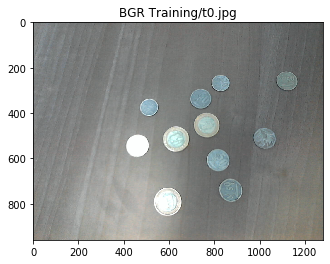

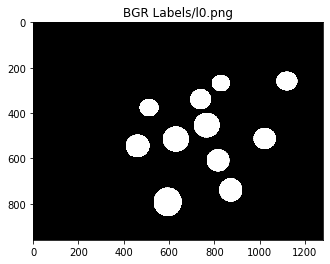

Shape of the image : (960, 1280, 3)
Image Hight 960
Image Width 1280
Dimension of Image 3


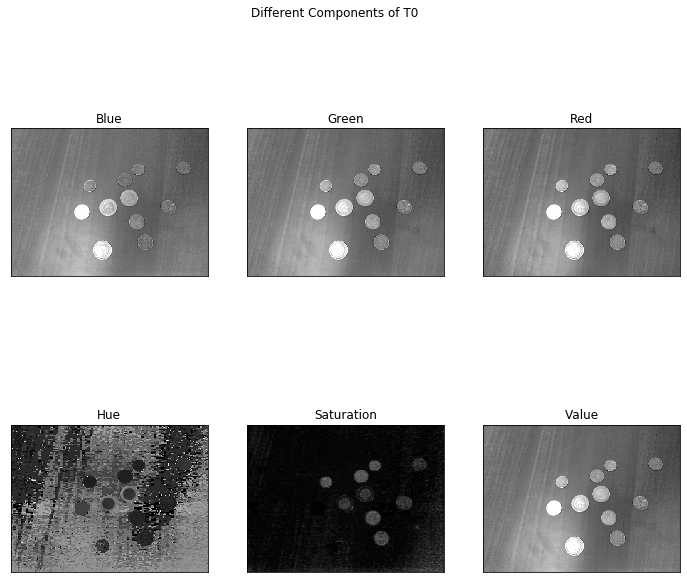

In [3]:
# Identifying Images
train_0 = read_image("Training/t0.jpg")
mask_0  = read_image("Labels/l0.png")

# Get Image States
print('Shape of the image : {}'.format(train_0.shape))
print('Image Hight {}'.format(train_0.shape[0]))
print('Image Width {}'.format(train_0.shape[1]))
print('Dimension of Image {}'.format(train_0.ndim))
img_size = train_0.shape[:2]
width, height = img_size
show_components(train_0, "T0")

The `value` field of `HSV` seems to give a reasonable differentiation between the desk and the coin pixels.

In [4]:
# Number of coin pixels vs desk pixels in first image
train_bgr = read_image("Training/t0.jpg",display=False)
train_hsv = cv2.cvtColor(train_bgr, cv2.COLOR_BGR2HSV)
train_mask = cv2.cvtColor(cv2.imread('Labels/l0.png'), cv2.COLOR_BGR2GRAY)
# Make mask more defined
train_mask = np.where(train_mask > 230, 255, 0)
print('Coin pixels: {}'.format(np.sum(train_mask==255)))
print('Non-coin pixels: {}'.format(np.sum(train_mask==0)))

Coin pixels: 87195
Non-coin pixels: 1141605


In [5]:
def train_test_set(image_path="Training/", mask_path="Labels/", image_size=img_size):
    """
    Given the directory for masks and images, loads all images and separate testing and training data
    """
    _, _, images = next(os.walk(image_path))
    _, _, masks  = next(os.walk(mask_path))
    num_images = len(images)
    num_masks  = len(masks)
    num_test_images = num_images - num_masks
    print("There are", num_masks, "Training images and",num_test_images,"Testing Images")
    train_images = []
    train_masks = [] 
    test_images = []
    flat_size = img_size[0]*img_size[1]
    print("Loading Training Data")
    for i in tqdm(range(num_masks)):
        image_name = image_path + "t" + str(i)+".jpg"
        image = cv2.cvtColor(cv2.imread(image_name), cv2.COLOR_BGR2HSV) / 255.0
        image = np.rollaxis(image, 2, 0).reshape(3, flat_size)
        train_images.append(image)
        
        mask_name = mask_path + "l"+ str(i)+".png"
        mask = cv2.cvtColor(cv2.imread(mask_name), cv2.COLOR_BGR2GRAY) / 255.0
        mask = np.where(mask<0.9, 0, 1).reshape(flat_size)
        train_masks.append(mask)
    
    print("Loading Testing Data")
    for i in tqdm(range(num_test_images,num_images)):
        image_name = image_path + "t" + str(i)+".jpg"
        image = read_image(image_name, display = False)
        test_images.append(color_norm_flatten(image, flat_size))
    print("Dataset Loaded")
    return train_images, train_masks, test_images

In [6]:
train_images, train_mask, test_images = train_test_set()

There are 105 Training images and 102 Testing Images
Loading Training Data



Loading Testing Data



Dataset Loaded


## E Step
$$
\begin{array}{l}{=\frac{\lambda_{k} \mathrm{Norm}_{\mathrm{x}_{i}}\left[\mu_{k}, \Sigma_{k}\right]}{\sum_{j=1}^{K} \lambda_{j} \operatorname{Norm}_{\mathrm{x}_{i}}\left[\mu_{j}, \Sigma_{j}\right]}} \\ {=r_{i k}}\end{array}
$$

In [7]:
def e_step(x, params):
    """
    Expecation step, takes in x and returns the r
    """
    r = []
    sum_r = 0
    for 𝜆, 𝜇, 𝜎 in params:
        r_ik = 𝜆 * stats.multivariate_normal.pdf(x, mean=𝜇, cov=𝜎, allow_singular=True)
        r.append(r_ik)
        sum_r += r_ik

    return np.array(r) / sum_r

In [8]:
# Test data for E-Step taken from 2017 November Exam
p = np.array([[0.5,250,10],[0.5,20,10]])
x_test = np.array([255,255,1,3,3])
e_step(x_test, p)

array([[1., 1., 0., 0., 0.],
       [0., 0., 1., 1., 1.]])

Expected output:


|n|x|R0|R1|
|---|---|---|---|
|0|255|1|0|
|1|255|1|0|
|2|1|0|1|
|3|3|0|1|
|4|3|0|1|

## M-Step

$$
\begin{aligned} \lambda_{k}^{[t+1]} &=\frac{\sum_{i=1}^{I} r_{i k}}{\sum_{j=1}^{K} \sum_{i=1}^{I} r_{i j}} \\ \boldsymbol{\mu}_{k}^{[t+1]} &=\frac{\sum_{i=1}^{I} r_{i k} \mathbf{x}_{i}}{\sum_{i=1}^{I} r_{i k}} \\ \boldsymbol{\Sigma}_{k}^{[t+1]} &=\frac{\sum_{i=1}^{I} r_{i k}\left(\mathbf{x}_{i}-\boldsymbol{\mu}_{k}^{[t+1]}\right)\left(\mathbf{x}_{i}-\boldsymbol{\mu}_{k}^{[t+1]}\right)^{T}}{\sum_{i=1}^{I} r_{i k}} \end{aligned}
$$

In [9]:
def m_step(x, r, parameters, two_dim = True):
    """
    Maximisation Step, takes in x and r and maximises the parameters
    """
    new_parameters = []
    for i, (𝜆, 𝜇, 𝜎) in enumerate(parameters):
        ri_sum = np.sum(r[i])
        r_sum = np.sum(r)
        𝜆  = ri_sum / r_sum
        if two_dim:
            𝜇 = np.sum(r[i] * x, axis=1)/ri_sum
            diff = x.T - 𝜇
            cov_i =np.dot(diff.T, np.multiply(r[i].reshape(len(r[i]),1), diff))
            𝜎 = ( cov_i / r[i].sum()) + 1e-4*np.eye(cov_i.shape[0])
        
        else:
            𝜇 = np.sum(r[i]*x)/np.sum(r[i])
            covar_sum = 0
            for j in range(len(x)):
                covar_sum += (r[i][j] * (x[j]-𝜇)*(x[j]-𝜇).T)/np.sum(r[i])
            𝜎 = covar_sum
        new_parameters.append((𝜆, 𝜇, 𝜎))
    return new_parameters

In [10]:
# Test data for M-step taken from Test 2 2017
x_ri = np.array([0, 0.1, 1.1, 1.2, 0.3])
ri_0 = np.array([0.606, 0.593, 0.402, 0.378, 0.563])
ri_1 = np.array([0.394, 0.407, 0.598, 0.622, 0.437])
ris = np.array([ri_0, ri_1])
p = np.array([[0.5, 0.5, 0.4], [0.5, 0.75, 0.3]])
new_p = m_step(x_ri,ris, p, two_dim = False)
print("𝜆",new_p[0][0],new_p[1][0])
print("𝜇",new_p[0][1],new_p[1][1])
print("𝜎",new_p[0][2]**2,new_p[1][2])
# This was working, although I duffed it at some stage

𝜆 0.5084 0.4915999999999999
𝜇 0.4421715184893785 0.6411716842961759
𝜎 0.0539327011420991 0.26532686149276935


Correct output:


|#|𝜆|𝜇|𝜎|
|---|---|---|---|
|0|0.5084|0.44217152|0.23223415|
|1|0.4916|0.64117168|0.26532686|


In [11]:
def fit(X, K):
    """
    Initialise the parameters and run the m step and e step
    """
    parameters = []
    dims = train_images[0].shape[0]
    for k in range(K):
        𝜆 = 1.0 / K
        𝜇 = np.random.rand(dims)
        𝜎 = np.eye(dims)
        parameters.append((𝜆, 𝜇, 𝜎))

    for x in X:
        r = e_step(x.T, parameters)
        parameters = m_step(x, r, parameters)
        break

    return parameters

In [12]:
def pdf(x, parameters):
    """
    Given a point return its probability, given the parameters for all distributions.
    """
    p = 0
    for 𝜆, 𝜇, 𝜎 in parameters:
        p += 𝜆 * stats.multivariate_normal.pdf(x, mean=𝜇, cov=𝜎, allow_singular=True)
    return p

In [13]:
train_coin = []
train_desk = []

#Uses 80% the coin & desk pixels 
train_len = int(len(train_images)*0.8)
for i in range(train_len):
    img = train_images[i]
    mask = train_mask[i]
    # Isolate Coin pixels and desk pixels
    coin = img[:,np.where(mask==0.0)][:, 0, :]
    desk = img[:,np.where(mask==1.0)][:, 0, :]
    train_coin.append(coin)
    train_desk.append(desk)

In [14]:
print('Learning coin pixel parameters')
coin_params = fit(train_coin, K=2)
print('Learning desk pixel parameters')
desk_params = fit(train_desk, K=2)

Learning coin pixel parameters
Learning desk pixel parameters


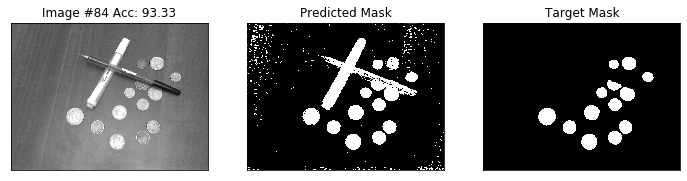

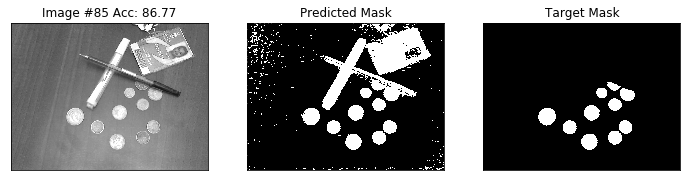

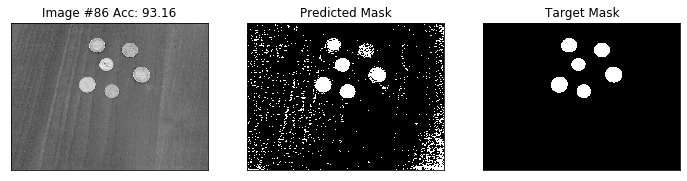

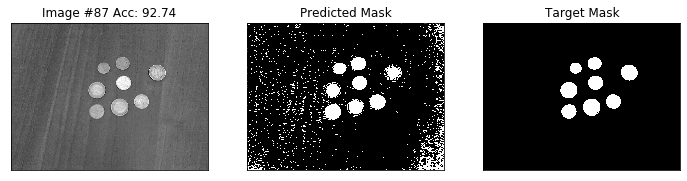

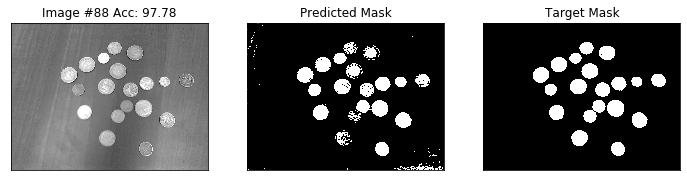

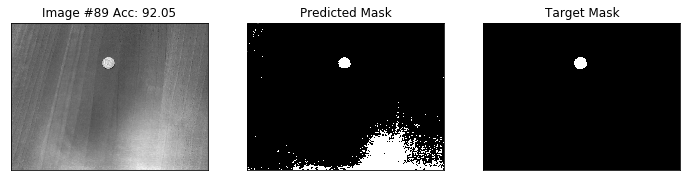

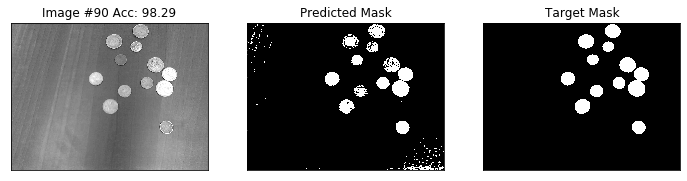

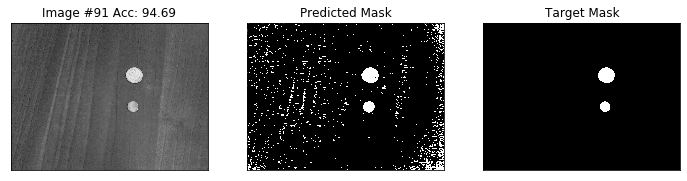

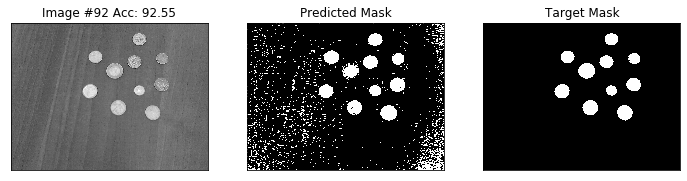

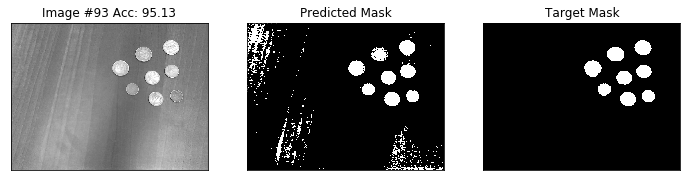

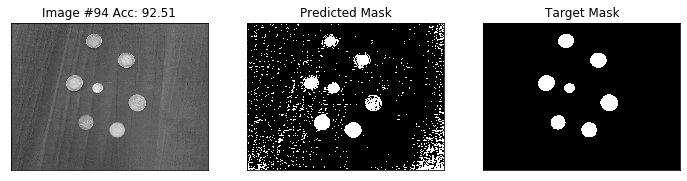

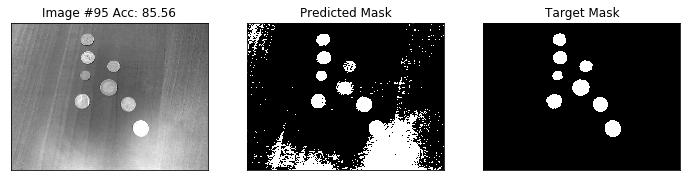

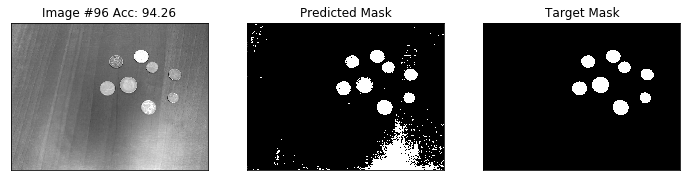

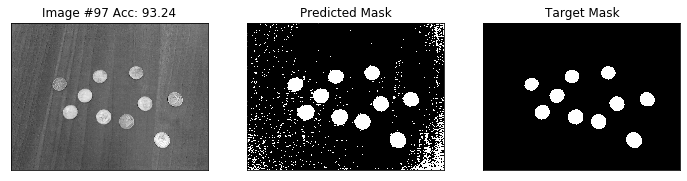

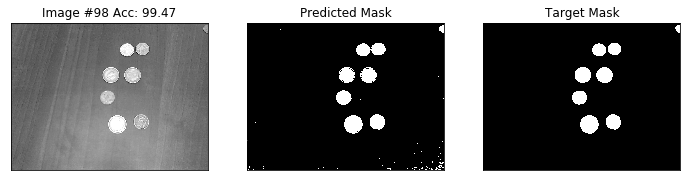

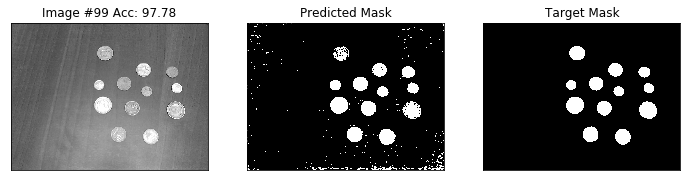

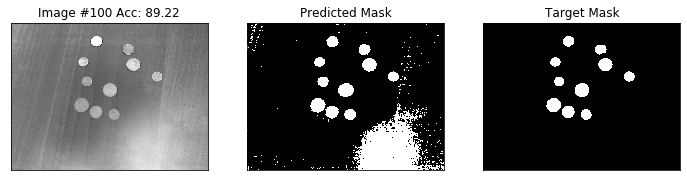

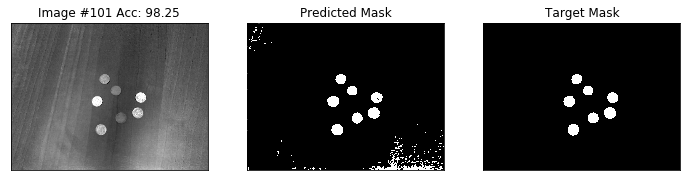

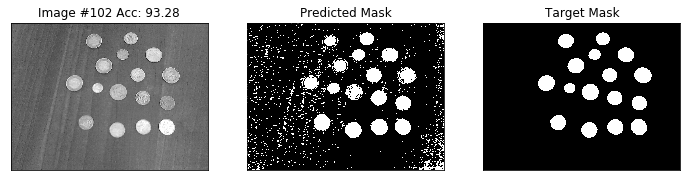

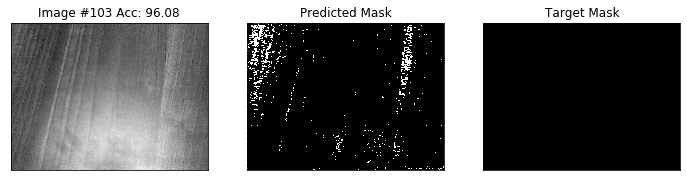

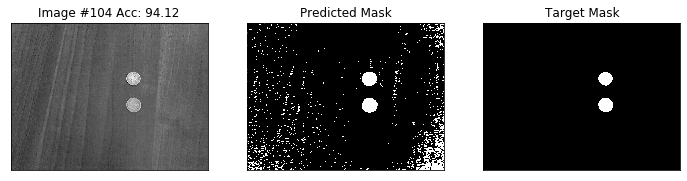

In [15]:
test_size = len(test_images)
for i in range(train_len,test_size):
    test_img = train_images[i]
    p_coin = pdf(test_img.T, coin_params)
    p_desk = pdf(test_img.T, desk_params)
    # Bayes
    p = p_coin / (p_coin + p_desk)
    # Invert to make black
    pred = 1 - (p > 0.5)
    
    plt.figure(figsize=(12, 10))
    plt.subplot(131)
    plt.imshow(train_images[i][2].reshape(img_size),cmap='gray')
    m = train_mask[i]
    t = "Image #"+str(i)+ " Acc: "+str(round(np.mean(pred==m)*100,2))
    plt.title(t)
    plt.subplot(132)
    plt.imshow(pred.reshape(img_size), cmap= 'gray')
    plt.title("Predicted Mask")
    
    plt.subplot(133)
    plt.imshow(m.reshape(img_size),cmap='gray')
    plt.title("Target Mask")
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
    
    # Save noteworthy Images
    if i in [98,85]:
        n = str(i)+".png"
        plt.savefig(n)
    plt.show()

In [16]:
def test_accuracy(coin_params, desk_params, start=train_len, stop = train_len+20, images = train_images, verbose=False):
    """
    Uses two trained GMMs to try and mask 20 test images and then returns the average accuracy
    """
    accuracies = np.zeros(stop-start)
    
    for i in tqdm(range(start, stop)):
        test_img = images[i]
        p_coin = pdf(test_img.T, coin_params)
        p_desk = pdf(test_img.T, desk_params)
        p = p_coin / (p_coin + p_desk)
        # Invert to make black
        pred = 1 - (p > 0.5)
        m = train_mask[i]
        accuracies[i-start] = np.mean(pred==m)*100
        if verbose:
            print("Image #",i," Acc:",round(accuracies[i-start],2))
    return np.mean(accuracies)

In [17]:
acc = []
times = []
comps = np.arange(1,11)
for i in comps:
    coin_params = fit(train_coin, K=i)
    desk_params = fit(train_desk, K=i)
    print("Calculating Accuracy of Model Trained with",i,"components")
    t0 = time.time()
    a = test_accuracy(coin_params, desk_params)
    t1 = time.time()
    times.append(t1-t0)
    acc.append(a)
    print("Accuracy =",round(a, 2),"\n")

Calculating Accuracy of Model Trained with 1 components



Accuracy = 93.8 

Calculating Accuracy of Model Trained with 2 components



Accuracy = 93.81 

Calculating Accuracy of Model Trained with 3 components



Accuracy = 93.8 

Calculating Accuracy of Model Trained with 4 components



Accuracy = 93.8 

Calculating Accuracy of Model Trained with 5 components



Accuracy = 93.8 

Calculating Accuracy of Model Trained with 6 components



Accuracy = 93.8 

Calculating Accuracy of Model Trained with 7 components



Accuracy = 93.8 

Calculating Accuracy of Model Trained with 8 components



Accuracy = 93.8 

Calculating Accuracy of Model Trained with 9 components



Accuracy = 93.8 

Calculating Accuracy of Model Trained with 10 components



Accuracy = 93.8 



In [18]:
print("The best overall accuracy was achieved with",comps[np.argmax(acc)],"components")
for i,c in enumerate(comps):
    print("Components:",c,"Acc:",round(acc[i],2), "Time:",round(times[i],2))
    
print("The accuracy over all components was", round(np.mean(acc),2))

The best overall accuracy was achieved with 2 components
Components: 1 Acc: 93.8 Time: 2.34
Components: 2 Acc: 93.81 Time: 4.67
Components: 3 Acc: 93.8 Time: 7.08
Components: 4 Acc: 93.8 Time: 9.58
Components: 5 Acc: 93.8 Time: 11.62
Components: 6 Acc: 93.8 Time: 13.98
Components: 7 Acc: 93.8 Time: 16.17
Components: 8 Acc: 93.8 Time: 18.92
Components: 9 Acc: 93.8 Time: 21.87
Components: 10 Acc: 93.8 Time: 23.47
The accuracy over all components was 93.8


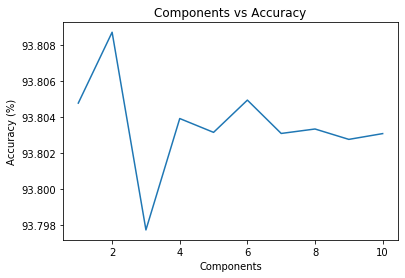

In [19]:
plt.plot(comps, acc)
plt.title("Components vs Accuracy")
plt.xlabel("Components")
plt.ylabel("Accuracy (%)")
plt.savefig("acuracy_comps.png")
plt.show()

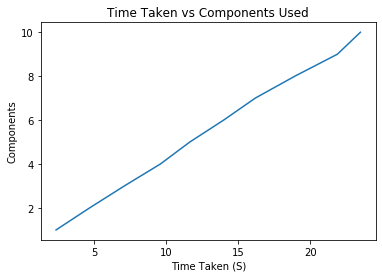

In [20]:
plt.plot(times, comps)
plt.xlabel("Time Taken (S)")
plt.ylabel("Components")
plt.title("Time Taken vs Components Used")
plt.savefig("Timetaken.png")
plt.show()